In [14]:
# unit test
import unittest

# model and transform
import torchvision
from torchvision import transforms
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights
from torchvision.models.feature_extraction import get_graph_node_names

# "helper" needs to be part of sys path
import sys
sys.path.insert(0, "helper")
sys.path.insert(0, "/helper")
sys.path.insert(0, "./helper")
sys.path.insert(0, "../helper")
print(sys.path)

device="cpu"

%load_ext autoreload
%autoreload 2

# own module
from visualisation.feature_map import *
from model.decentblock import *

['../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', 'C:\\Users\\Christina\\Documents\\datasceyence\\examples', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\python39.zip', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\DLLs', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy', '', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages\\pixelssl-0.1.4-py3.9.egg', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages\\win32', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages\\Pythonwin']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autorel

In [48]:
from visualisation.hook import Hook

import matplotlib.pyplot as plt
import numpy as np

import torch

from PIL import Image

import random


class FeatureMap2():
    # =============================================================================
    # ??? https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
    # ??? https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c
    # =============================================================================

    def __init__(self, model, layer, device="cpu", ckpt_net_path=None, iterations=200, lr=1):
        # =============================================================================
        # Initialise iter, lr, model, layer
        # =============================================================================

        # settings for dreams
        self.iterations=iterations
        self.lr=lr
        self.device = device

        # model
        if ckpt_net_path is not None:
            self.model.load_state_dict(torch.load(ckpt_net_path)["model"]) # 'dir/decentnet_epoch_19_0.3627.ckpt'
        
        
        self.model = model.eval()
        
        # the (conv) layer to be visualised
        self.layer = layer
        print("Layer:", self.layer)

    def run(self, img_tensor):
        # =============================================================================
        # Feature map visualisation using hooks       
        # A high activation means a certain feature was found. 
        # A feature map is called the activations of a layer after the convolutional operation.
        # =============================================================================
        
        self.img_tensor = img_tensor
        
        
        self.img_tensor = self.img_tensor.to(self.device)
        if len(self.img_tensor) == 3:
            self.img_tensor = self.img_tensor.unsqueeze_(0)
            
        print(self.img_tensor.shape) 
            
        hook = Hook(self.layer)
        output = self.model(img_tensor)
        self.feature_maps = hook.output.squeeze()
        
        print('o', output.shape)
        print('i', self.img_tensor.shape)
        print('f', self.feature_maps.shape)

    def plot(self, path=None):
        # =============================================================================
        # plot 15 random feature maps + original image
        # =============================================================================
        fig, axarr = plt.subplots(4, 4)
        # plt.figure(figsize=(100,100))
        amount = self.feature_maps.shape[0]
        print("amount of feature maps:", amount)
        if amount < 16:
            sample_amount = amount
        else:
            sample_amount = 16
        random_samples = random.sample(range(0, amount), sample_amount)
        counter = 0  
        idx,idx2 = [0, 0]
        for idx in range(0, 4):
            for idx2 in range(0, 4):
                axarr[idx, idx2].axis('off')
                try:
                    axarr[idx, idx2].imshow(self.feature_maps[random_samples[counter]].cpu().detach().numpy())
                    counter += 1
                except:
                    pass
                
        # overwrite first image with original image
        try:
            print("1", self.img_tensor.shape)
            axarr[idx,idx2].imshow(self.img_tensor.cpu().detach().numpy().transpose(1, 2, 0))
            
        except:
            try:
                print("2", self.img_tensor.squeeze().shape)
                axarr[idx,idx2].imshow(self.img_tensor.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
                
            except:
                try: 
                    print("3", self.img_tensor.squeeze(1).shape)
                    axarr[idx,idx2].imshow(self.img_tensor.squeeze(1).cpu().detach().numpy().transpose(1, 2, 0))
                except:
                    print("not possible to show original image")
        
        if path is not None:
            fig.savefig(path)
        else:
            plt.show()
        


    

    
    
    
    
    
    



# Feature map

torch.Size([3, 2056, 2124])
**************************************************
example graph nodes: ['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1']
**************************************************
Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([1, 3, 2056, 2124])
o torch.Size([1, 1000])
i torch.Size([1, 3, 2056, 2124])
f torch.Size([64, 514, 531])
amount of feature maps: 64
1 torch.Size([1, 3, 2056, 2124])
2 torch.Size([3, 2056, 2124])


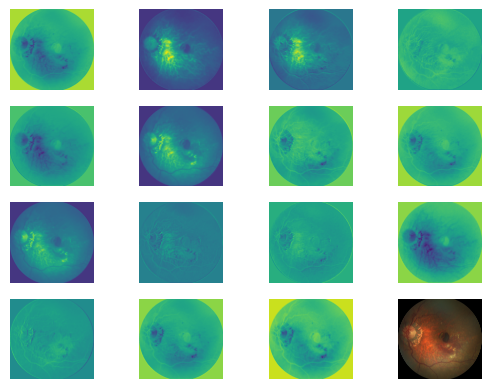

In [49]:
# get one example image
ichallenge_data = torchvision.datasets.ImageFolder('example_data/eye')
img, label = ichallenge_data.__getitem__(1)

# tensor preparation
to_tensor = transforms.ToTensor()
img = to_tensor(img).to(device)

print(img.shape)

# model preparation
# model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1).to(device)

if False:
    model = DecentBlock("example_ckpt", "exp_1_mlp_c0_ep46_1.5189.ckpt", 2, device)
else:
    model = DecentBlock(None, None, 2, device)
    import torchvision
    model = torchvision.models.resnet18()

# layer to focus on
print("*"*50)
print("example graph nodes:", get_graph_node_names(model)[0][0:20])
print("*"*50)
layer = model.layer1[0].conv2 # model.decent_block.decent_block_116[0][1] # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv

# run feature map
dd = FeatureMap2(model=model, layer=layer, device=device, iterations=1000, lr=0.1) # i think learning rate and iterations is useless here ... todo: change
dd.run(img)
dd.plot()

In [46]:
tmp = torchvision.models.resnet18()
tmp.layer1[0].conv2

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

## same thing

**************************************************
example graph nodes: ['x', 'decent_block.decent_block_116.0.0', 'decent_block.decent_block_116.0.1', 'decent_block.decent_block_116.0.2', 'decent_block.decent_block_116.1', 'decent_block.decent_block_116.2.0.branch1.0', 'decent_block.decent_block_116.2.0.branch1.1', 'decent_block.decent_block_116.2.0.branch1.2', 'decent_block.decent_block_116.2.0.branch1.3', 'decent_block.decent_block_116.2.0.branch1.4', 'decent_block.decent_block_116.2.0.branch2.0', 'decent_block.decent_block_116.2.0.branch2.1', 'decent_block.decent_block_116.2.0.branch2.2', 'decent_block.decent_block_116.2.0.branch2.3', 'decent_block.decent_block_116.2.0.branch2.4', 'decent_block.decent_block_116.2.0.branch2.5', 'decent_block.decent_block_116.2.0.branch2.6', 'decent_block.decent_block_116.2.0.branch2.7', 'decent_block.decent_block_116.2.0.cat', 'decent_block.decent_block_116.2.0.size']
**************************************************
Layer: BatchNorm2d(24, eps=1e-0

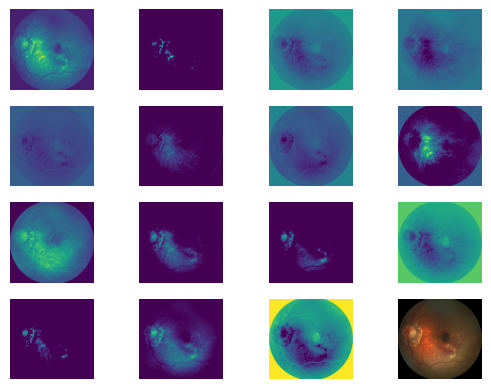

In [22]:
# get one example image
ichallenge_data = torchvision.datasets.ImageFolder('example_data/eye')
img, label = ichallenge_data.__getitem__(1)

# tensor preparation
to_tensor = transforms.ToTensor()
img = to_tensor(img).to(device)

# model preparation
# model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1).to(device)
from model.decentblock import *
if True:
    model = DecentBlock("example_ckpt", "exp_1_mlp_c3_ep43_1.2093.ckpt", 2, device)
else:
    model = DecentBlock(None, None, 2, device)

# layer to focus on
print("*"*50)
print("example graph nodes:", get_graph_node_names(model)[0][0:20])
print("*"*50)
layer = model.decent_block.decent_block_116[0][1] # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv

# run feature map
dd = FeatureMap(model=model, layer=layer, device=device, iterations=1000, lr=0.1)
dd.run(img)
dd.plot()

## and again

**************************************************
example graph nodes: ['x', 'decent_block.decent_block_116.0.0', 'decent_block.decent_block_116.0.1', 'decent_block.decent_block_116.0.2', 'decent_block.decent_block_116.1', 'decent_block.decent_block_116.2.0.branch1.0', 'decent_block.decent_block_116.2.0.branch1.1', 'decent_block.decent_block_116.2.0.branch1.2', 'decent_block.decent_block_116.2.0.branch1.3', 'decent_block.decent_block_116.2.0.branch1.4', 'decent_block.decent_block_116.2.0.branch2.0', 'decent_block.decent_block_116.2.0.branch2.1', 'decent_block.decent_block_116.2.0.branch2.2', 'decent_block.decent_block_116.2.0.branch2.3', 'decent_block.decent_block_116.2.0.branch2.4', 'decent_block.decent_block_116.2.0.branch2.5', 'decent_block.decent_block_116.2.0.branch2.6', 'decent_block.decent_block_116.2.0.branch2.7', 'decent_block.decent_block_116.2.0.cat', 'decent_block.decent_block_116.2.0.size']
**************************************************
Layer: BatchNorm2d(24, eps=1e-0

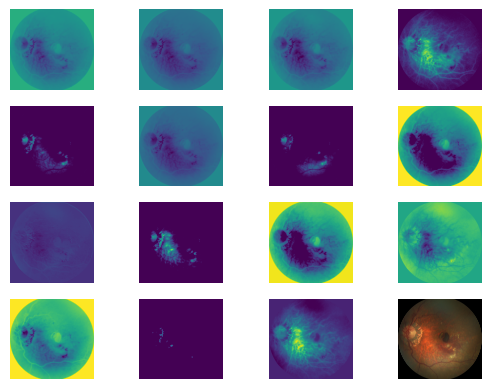

In [23]:
# get one example image
ichallenge_data = torchvision.datasets.ImageFolder('example_data/eye')
img, label = ichallenge_data.__getitem__(1)

# tensor preparation
to_tensor = transforms.ToTensor()
img = to_tensor(img).to(device)

# model preparation
# model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1).to(device)
from model.decentblock import *
if True:
    model = DecentBlock("example_ckpt", "exp_1_mlp_c5_ep36_1.1963.ckpt", 2, device)
else:
    model = DecentBlock(None, None, 2, device)

# layer to focus on
print("*"*50)
print("example graph nodes:", get_graph_node_names(model)[0][0:20])
print("*"*50)
layer = model.decent_block.decent_block_116[0][1] # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv

# run feature map
dd = FeatureMap(model=model, layer=layer, device=device, iterations=1000, lr=0.1)
dd.run(img)
dd.plot()